In [42]:
# Setup copied from Activity 3
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Note: UMAP requires: pip install umap-learn
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")
    print("You can skip UMAP and focus on PCA and t-SNE.")
    UMAP_AVAILABLE = False

# Anomaly Detection
from sklearn.ensemble import IsolationForest

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# Part 1: Clustering Analysis 

In [43]:
# File read and setup provided in Activity 3 template
df = pd.read_csv('../data/Mall_Customers.csv')
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

Shape: (200, 5)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

First few rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [44]:
# Check data types and missing values
print("Dataset Information:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Missing values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Basic statistics:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [45]:
# preprocessing

# set anual income to thousands
df['Annual Income (k$)'] = df['Annual Income (k$)'] * 1000

# rename columns for easier access
df.columns = ['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore'] 

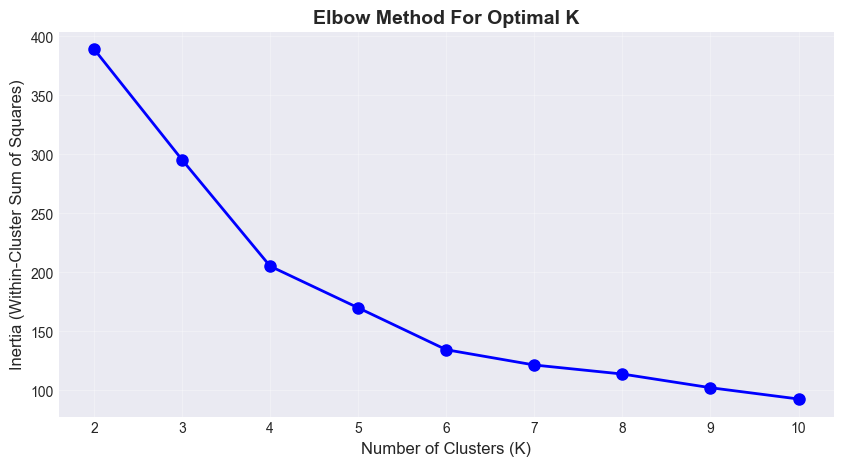


Inertia Values:
K=2: 389.386
K=3: 295.456
K=4: 205.225
K=5: 169.891
K=6: 134.353
K=7: 121.389
K=8: 113.727
K=9: 102.136
K=10: 92.550


In [46]:
# Get features, exclude customer id
feature_cols = ['Age', 'AnnualIncome', 'SpendingScore']
X = df[feature_cols].copy()

# Scale Age, annual income, spending score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia_values = []
K_range = range(2, 11)  # K from 2 to 10

for k in K_range:
    inertia = KMeans(n_clusters=k, random_state=42).fit(X_scaled).inertia_
    inertia_values.append(inertia)

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.show()

print("\nInertia Values:")
for k, inertia in zip(K_range, inertia_values):
    print(f"K={k}: {inertia:.3f}")

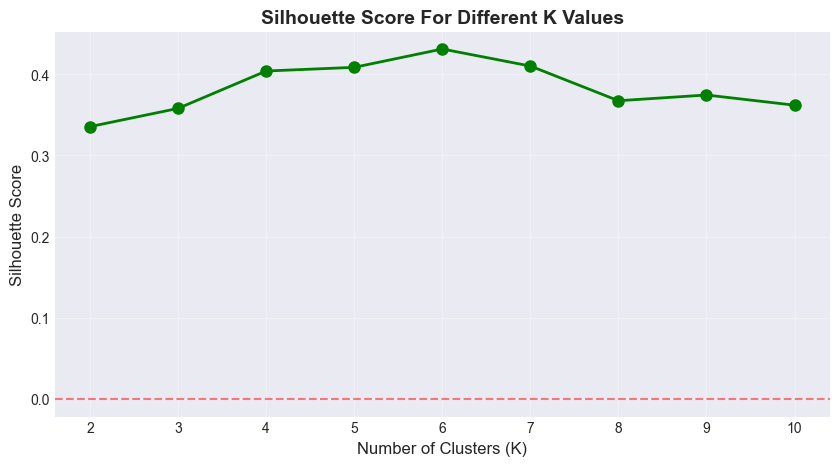


Silhouette Scores:
K=2: 0.335
K=3: 0.358
K=4: 0.404
K=5: 0.408
K=6: 0.431
K=7: 0.410
K=8: 0.367
K=9: 0.374
K=10: 0.362


In [47]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score For Different K Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.show()

# Print the scores
print("\nSilhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"K={k}: {score:.3f}")

## Optimal-K choice:

Our optimal k-choice is 6. Based on the elbow method, K=6 lies near the elbow of the graph where the inertia stops decreasing drastically. The silhouette score at K=6 is also the highest out of all K-values from 2 to 10. This means there are 6 types of customers with specific spending habits. There may also be data errors within those 6 clusters.

In [ ]:
# Create the model and determine count in each cluster
optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(X_scaled)

cluster_labels = kmeans_final.labels_

# Add cluster labels to original dataframe
df['Cluster'] = cluster_labels

print(f"✓ K-Means clustering completed with K={optimal_k}")
print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())

✓ K-Means clustering completed with K=4

Cluster distribution:
0    65
1    40
2    57
3    38
Name: Cluster, dtype: int64


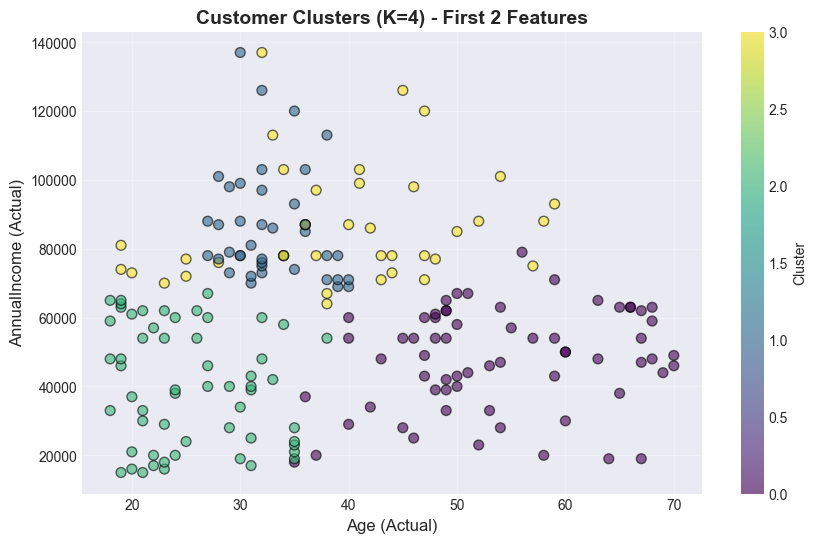

In [49]:
# Modified visualization helper function from Activity 3 template
def plot_clusters_2d(X, labels, feature_names, title="K-Means Clusters"):
    """
    Plot clusters using first two features.
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(scaler.inverse_transform(X)[:, 0], scaler.inverse_transform(X)[:, 1], c=labels, cmap='viridis',
                         alpha=0.6, edgecolors='k', s=50)
    plt.xlabel(f'{feature_names[0]} (Actual)', fontsize=12)
    plt.ylabel(f'{feature_names[1]} (Actual)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)

# Plot clusters
plot_clusters_2d(X_scaled, cluster_labels, feature_cols,
                title=f"Customer Clusters (K={optimal_k}) - First 2 Features")

plt.show()


# Part 2: Dimensionality Reduction

### PCA

In [50]:
# PCA
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_scaled)

print(f"PCA result shape: {X_pca.shape}")
print(f"\nExplained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

PCA result shape: (200, 2)

Explained variance ratio:
PC1: 0.443
PC2: 0.333
Total variance explained: 0.776


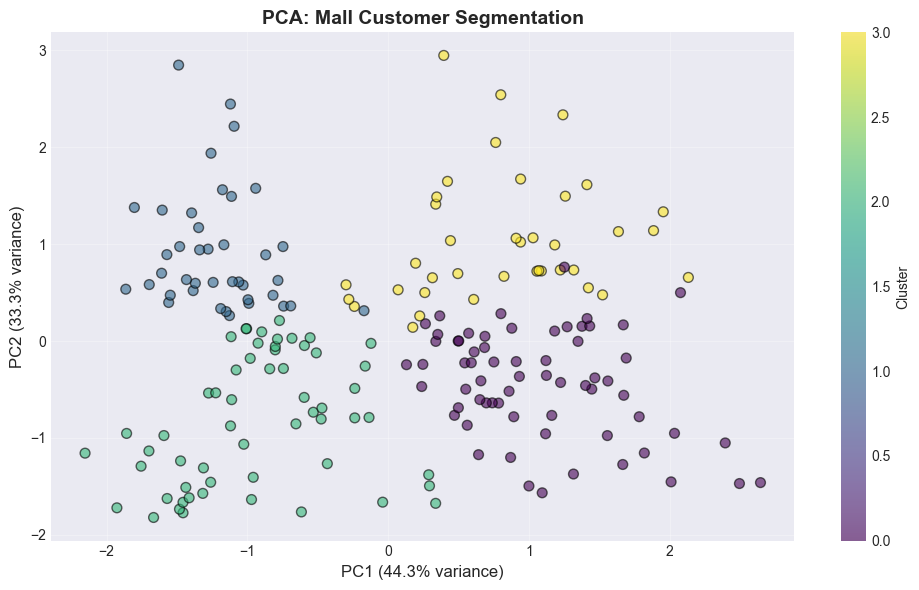

In [51]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                     cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('PCA: Mall Customer Segmentation', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### t-SNE

In [52]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

print(f"✓ t-SNE completed! Result shape: {X_tsne.shape}")

✓ t-SNE completed! Result shape: (200, 2)


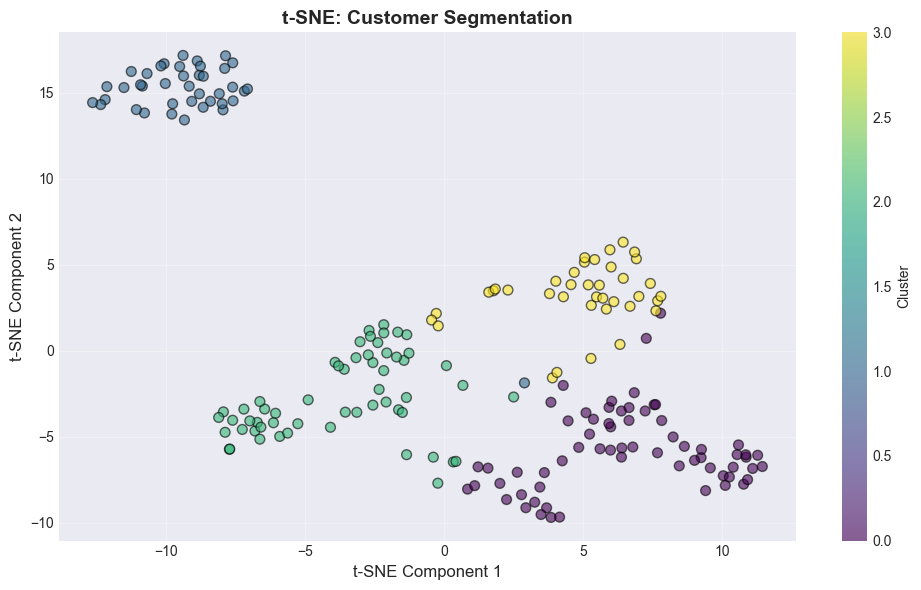

In [53]:
# Visualize t-SNE results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels,
                     cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE: Customer Segmentation', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### UMAP

In [54]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

print(f"✓ UMAP completed! Result shape: {X_umap.shape}")

✓ UMAP completed! Result shape: (200, 2)


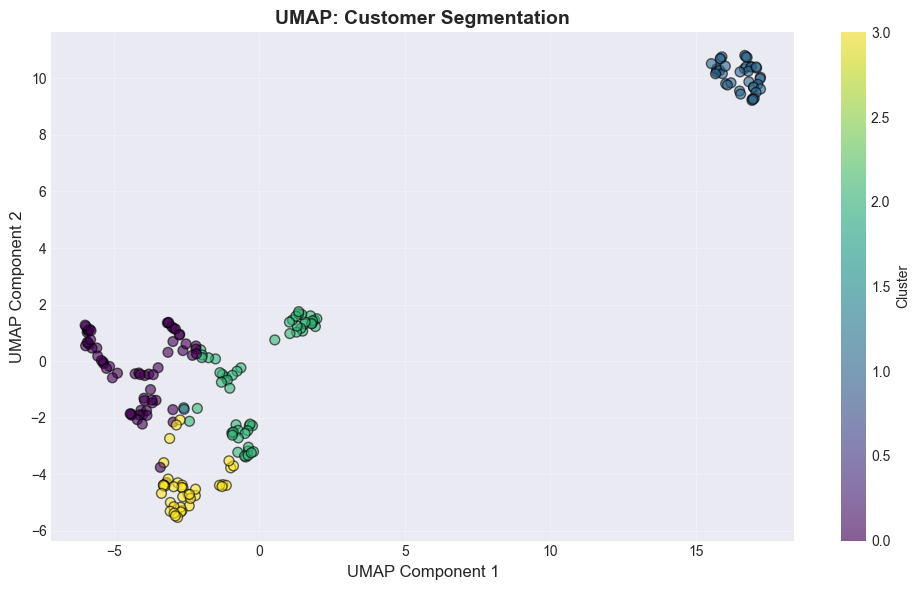

In [55]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels,
                        cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.title('UMAP: Customer Segmentation', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

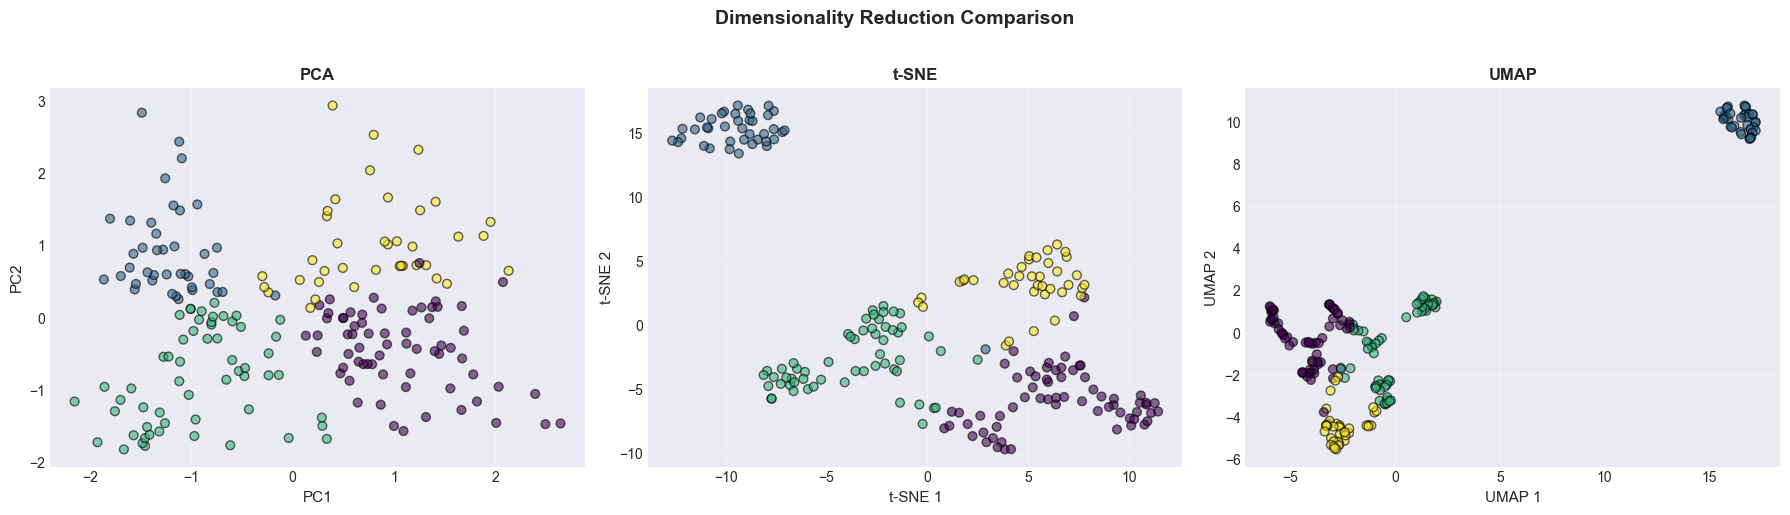

In [56]:
### Comparison
n_plots = 3
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]

# PCA plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                          cmap='viridis', alpha=0.6, edgecolors='k', s=40)
axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].set_title('PCA', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# t-SNE plot
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels,
                          cmap='viridis', alpha=0.6, edgecolors='k', s=40)
axes[1].set_xlabel('t-SNE 1', fontsize=11)
axes[1].set_ylabel('t-SNE 2', fontsize=11)
axes[1].set_title('t-SNE', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# UMAP plot (if available)
scatter3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels,
                            cmap='viridis', alpha=0.6, edgecolors='k', s=40)
axes[2].set_xlabel('UMAP 1', fontsize=11)
axes[2].set_ylabel('UMAP 2', fontsize=11)
axes[2].set_title('UMAP', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Dimensionality Reduction Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Analysis

#### Visualizations
Visualization with PCA showed that the global structure of points have no clear cluster boundaries but there are still visible groupings of points. Each cluster is also fairly spread out and do not cluster around an area. 

t-SNE visualization preserves local neighbourhoods and confirms that points are spread out within clusters. It also shows that some clusters have more visible boundaries than others such as the cluster in the top left.

UMAP visualization supports previous analyses from t-SNE and PCA but also it shows that there are clear clusters and groupings that can formed in the data. Since it better preserves global and local structure, we learn from the UMAP visualization that there is indeed a large difference between one cluster and the rest with the cluster being in the top right.

#### Key takeaways
- Data appears to be non-linear as t-SNE and UMAP show clusters better
- t-SNE and UMAP visualizations show that there is one cluster that is vastly different from the rest
- Aside from the outlier cluster, clusters do not have clear boundaries and generally bleed into each other

#### Method for Presentation

We select the t-SNE visualization method to present to business executives for the follow reasons:
- t-SNE shows that customers can be segmented
- t-SNE better shows local neighbourhoods for points which depicts that clusters overlap
- t-SNE and UMAP both show one outlier cluster but t-SNE shows it better with a less clutter graph

# Part 3: Anomaly Detection

# Part 4: Integrated Analysis